<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetection/blob/MLP_NeuralNetwork/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
33/33 [==============================] - 2s 19ms/step - loss: 0.5568 - accuracy: 0.9134 - val_loss: 0.3600 - val_accuracy: 0.9535
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.2518 - accuracy: 0.9339 - val_loss: 0.1552 - val_accuracy: 0.9535
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1704 - accuracy: 0.9339 - val_loss: 0.1343 - val_accuracy: 0.9535
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1452 - accuracy: 0.9339 - val_loss: 0.1191 - val_accuracy: 0.9535
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1167 - accuracy: 0.9339 - val_loss: 0.1058 - val_accuracy: 0.9535
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.9339 - val_loss: 0.0979 - val_accuracy: 0.9535
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0861 - accuracy: 0.9358 - val_loss: 0.0941 - val_accuracy: 0.9612
Epoch 8/100


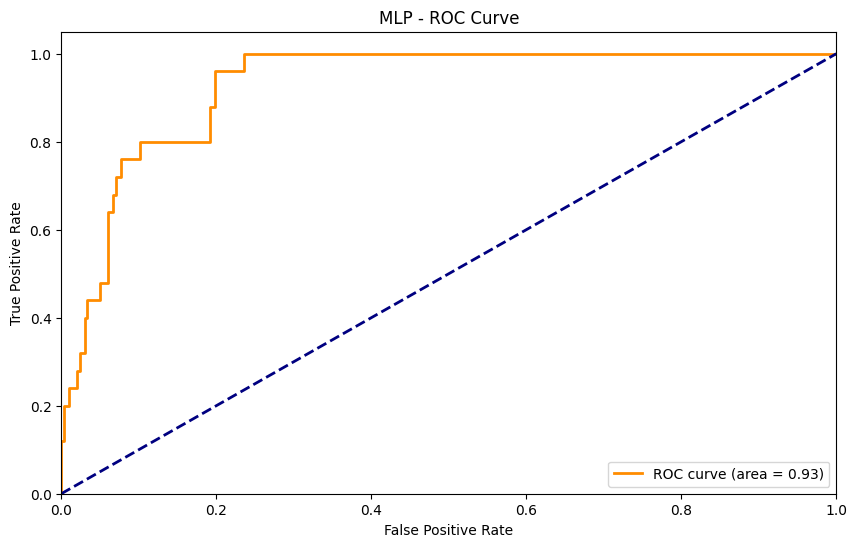

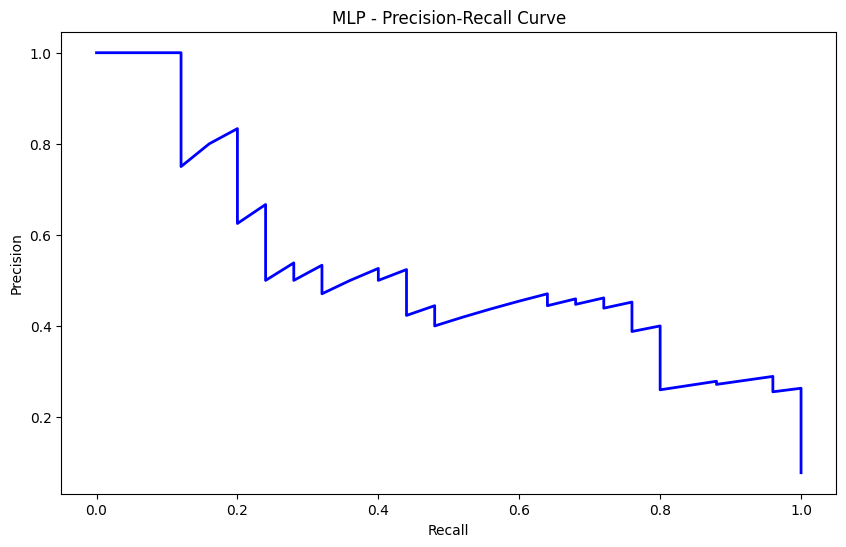

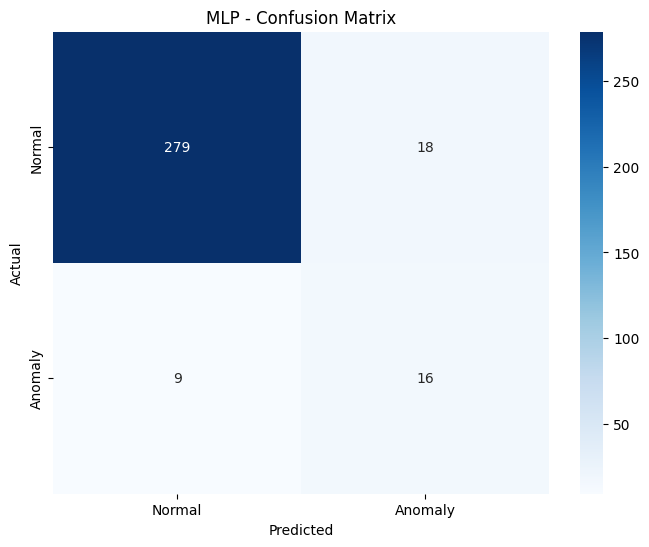

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Drop the 'idPunto' and 'note' columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build the MLP model
def build_mlp(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert X_train from sparse matrix to dense array
X_train_dense = X_train.toarray()

# Initialize and train the MLP model
mlp = build_mlp(X_train_dense.shape[1])
history = mlp.fit(X_train_dense, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


# Predict on the test set
y_pred_prob = mlp.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_roc_curve(y_test, y_pred_prob, "MLP - ROC Curve")

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

# Plot precision-recall curve
plot_precision_recall_curve(y_test, y_pred_prob, "MLP - Precision-Recall Curve")

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, "MLP - Confusion Matrix")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       297
           1       0.47      0.64      0.54        25

    accuracy                           0.92       322
   macro avg       0.72      0.79      0.75       322
weighted avg       0.93      0.92      0.92       322

F1 Score: 0.5423728813559322
Matthews Correlation Coefficient (MCC): 0.5045293954502952
Area Under the Precision-Recall Curve (AUC-PR): 0.5320898455784223
Optimal Threshold (Youden's Index): 0.00056868594


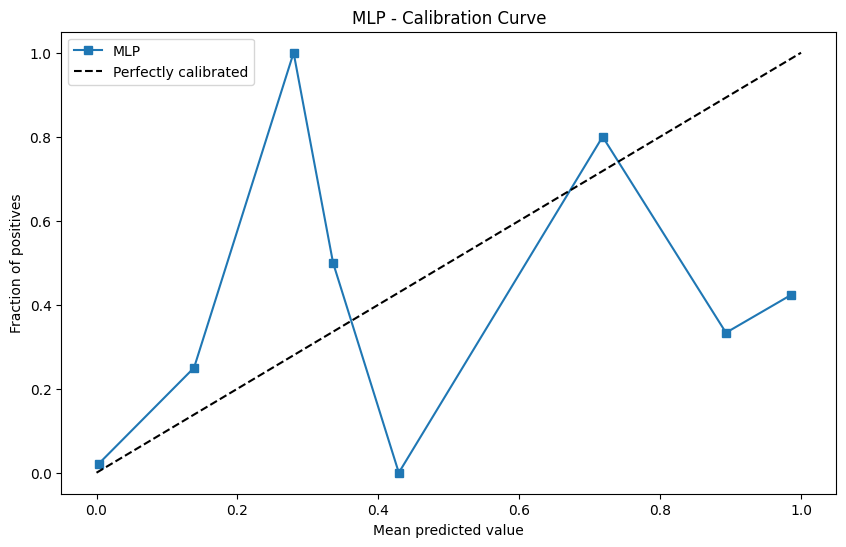

In [3]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, matthews_corrcoef, f1_score
from sklearn.calibration import calibration_curve

# Function to calculate F1 Score
def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

# Function to calculate Matthews Correlation Coefficient (MCC)
def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

# Function to calculate Area Under the Precision-Recall Curve (AUC-PR)
def calculate_auc_pr(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    return average_precision_score(y_true, y_pred_prob)

# Function to find optimal threshold using Youden's Index
def find_optimal_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Function to plot calibration curve
def plot_calibration_curve(y_true, y_pred_prob, title):
    plt.figure(figsize=(10, 6))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label="MLP")
    plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.title(title)
    plt.legend()
    plt.show()

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score:", calculate_f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient (MCC):", calculate_mcc(y_test, y_pred))
print("Area Under the Precision-Recall Curve (AUC-PR):", calculate_auc_pr(y_test, y_pred_prob))

# Find optimal threshold using Youden's Index
optimal_threshold = find_optimal_threshold(y_test, y_pred_prob)
print("Optimal Threshold (Youden's Index):", optimal_threshold)

# Plot calibration curve
plot_calibration_curve(y_test, y_pred_prob, "MLP - Calibration Curve")


Confusion Matrix:
[[279  18]
 [  9  16]]
Gini Coefficient: 0.8575084175084173
Kappa Statistic: 0.4973985431841832
Brier Score: 0.07756337643485384
Log Loss: 0.3488681449761076
Jaccard Index: 0.37209302325581395
Hamming Loss: 0.08385093167701864
KS Statistic: 0.7643097643097643


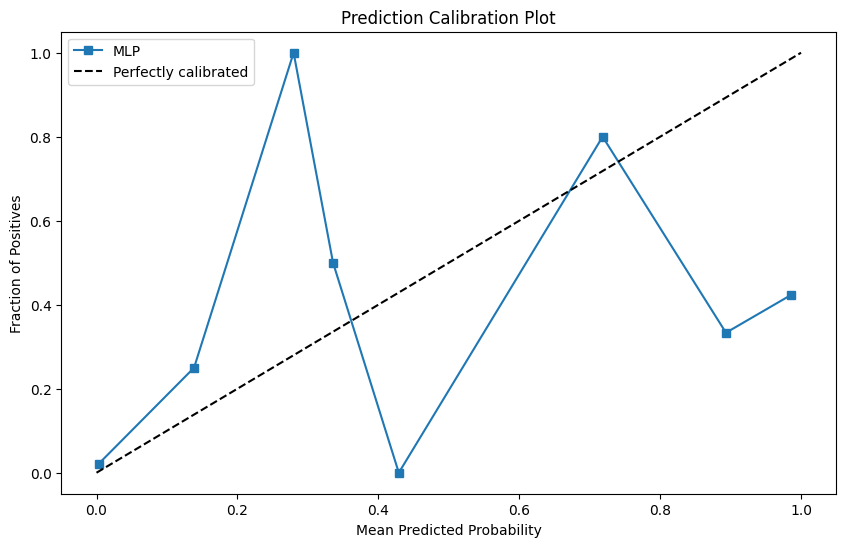

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score, brier_score_loss, log_loss, jaccard_score, hamming_loss
from scipy.stats import ks_2samp
import statsmodels.api as sm
from sklearn.calibration import calibration_curve


# Function to calculate Gini coefficient
def calculate_gini_coefficient(y_true, y_pred_prob):
    auc = roc_auc_score(y_true, y_pred_prob)
    gini = 2 * auc - 1
    return gini

# Function to calculate Kappa statistic
def calculate_kappa_statistic(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

# Function to calculate Brier score
def calculate_brier_score(y_true, y_pred_prob):
    return brier_score_loss(y_true, y_pred_prob)

# Function to calculate Log Loss
def calculate_log_loss(y_true, y_pred_prob):
    return log_loss(y_true, y_pred_prob)

# Function to calculate Jaccard Index
def calculate_jaccard_index(y_true, y_pred):
    return jaccard_score(y_true, y_pred)

# Function to calculate Hamming Loss
def calculate_hamming_loss(y_true, y_pred):
    return hamming_loss(y_true, y_pred)

# Function to calculate Kolmogorov-Smirnov (KS) Statistic
def calculate_ks_statistic(y_true, y_pred_prob):
    y_pred_prob_positive = y_pred_prob[y_true == 1].flatten()
    y_pred_prob_negative = y_pred_prob[y_true == 0].flatten()
    ks_statistic, _ = ks_2samp(y_pred_prob_positive, y_pred_prob_negative)
    return ks_statistic

# Function to plot Prediction Calibration Plot
def plot_prediction_calibration_plot(y_true, y_pred_prob):
    fig, ax = plt.subplots(figsize=(10, 6))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label="MLP")
    plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Prediction Calibration Plot')
    plt.legend()
    plt.show()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Gini Coefficient:", calculate_gini_coefficient(y_test, y_pred_prob))
print("Kappa Statistic:", calculate_kappa_statistic(y_test, y_pred))
print("Brier Score:", calculate_brier_score(y_test, y_pred_prob))
print("Log Loss:", calculate_log_loss(y_test, y_pred_prob))
print("Jaccard Index:", calculate_jaccard_index(y_test, y_pred))
print("Hamming Loss:", calculate_hamming_loss(y_test, y_pred))
print("KS Statistic:", calculate_ks_statistic(y_test, y_pred_prob))

# Plot Prediction Calibration Plot
plot_prediction_calibration_plot(y_test, y_pred_prob)
